In [ ]:
!pip install pyspark
!pip install imblearn

In [ ]:
# Importar modulos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import builtins
from scipy.stats import chi2_contingency
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier

# Crear sesión de Spark
spark = SparkSession.builder.getOrCreate()

In [ ]:
# FUNCIONES

# Obtiene primer elemento separado por -
def get_first_part(value):
    if value is not None:
      value_str  = str(value)
      return value_str.split('-')[0]
    return value

split_udf = udf(get_first_part, StringType())

# Clasificación etaria basada en Chile
def classify_age(age):
    if age is None:
        return "Desconocido"
    elif age < 0 or age > 110:
        return "Inválido"
    elif age <= 12:
        return "Niñez"
    elif age <= 19:
        return "Adolescencia"
    elif age <= 29:
        return "Juventud"
    elif age <= 59:
        return "Adultez"
    else:
        return "Adulto Mayor"

classify_age_udf = udf(classify_age, StringType())

# Función para calcular V de Cramer
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = builtins.max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    denom = builtins.min((kcorr - 1), (rcorr - 1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0

In [ ]:
# Inicializar contexto/session
df_dataset = spark.read.csv("dataset_elpino.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")
df_procedimientos = spark.read.csv("CIE_9.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")
df_diagnosticos = spark.read.csv("CIE_10.csv",header=True,sep=";",inferSchema=True,mode="DROPMALFORMED")

In [ ]:
# TRATAMIENTO DE DATOS

# Limpiar nombres de columnas
for col_name in df_dataset.columns:
    new_col = col_name.replace("(", "").replace(")", "").replace("[", "").replace("]", "").replace(" ", "_").replace("cod+des", "codes")
    df_dataset = df_dataset.withColumnRenamed(col_name, new_col)

# Aplicar función para extraer el código de diagnósticos y procedimientos
for col_name in df_dataset.columns:
    if "Diag" in col_name or "Proced" in col_name:
        df_dataset = df_dataset.withColumn(col_name, split_udf(col(col_name)))

# Aplicar función para transformar edad en rango etario
df_dataset = df_dataset.withColumn("Edad_grupo", classify_age_udf(df_dataset["Edad_en_años"]))

# Aplicar cast a columna Edad para que este en int
df_dataset = df_dataset.withColumn("Edad_en_años", col("Edad_en_años").cast("int"))

In [ ]:
# Fase de Exploracion Dataset
df_dataset.show(5, truncate=False)
df_dataset.printSchema()
df_dataset.count()

# Guardar dataset originales
df_datasetSparkOriginal = df_dataset
df_datasetPandasOriginal = df_dataset.toPandas()

+-----------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-------------------------+--------------------------+--------------------------+--------------------------+------------------

Filas totales: 14561
Filas válidas (edad entre 0 y 110): 14560
Outliers a eliminar: 1
                            Porcentaje_nulos
Diag_01_Principal_codes                  0.0
Diag_02_Secundario_codes                 0.0
Diag_03_Secundario_codes                 0.0
Diag_04_Secundario_codes                 0.0
Diag_05_Secundario_codes                 0.0
...                                      ...
Proced_30_Secundario_codes               0.0
Edad_en_años                             0.0
Sexo_Desc                                0.0
GRD                                      0.0
Edad_grupo                               0.0

[69 rows x 1 columns]



count    14560.000000
mean        39.420948
std         24.673132
min          0.000000
25%         23.000000
50%         36.000000
75%         60.000000
max        101.000000
Name: Edad_en_años, dtype: float64


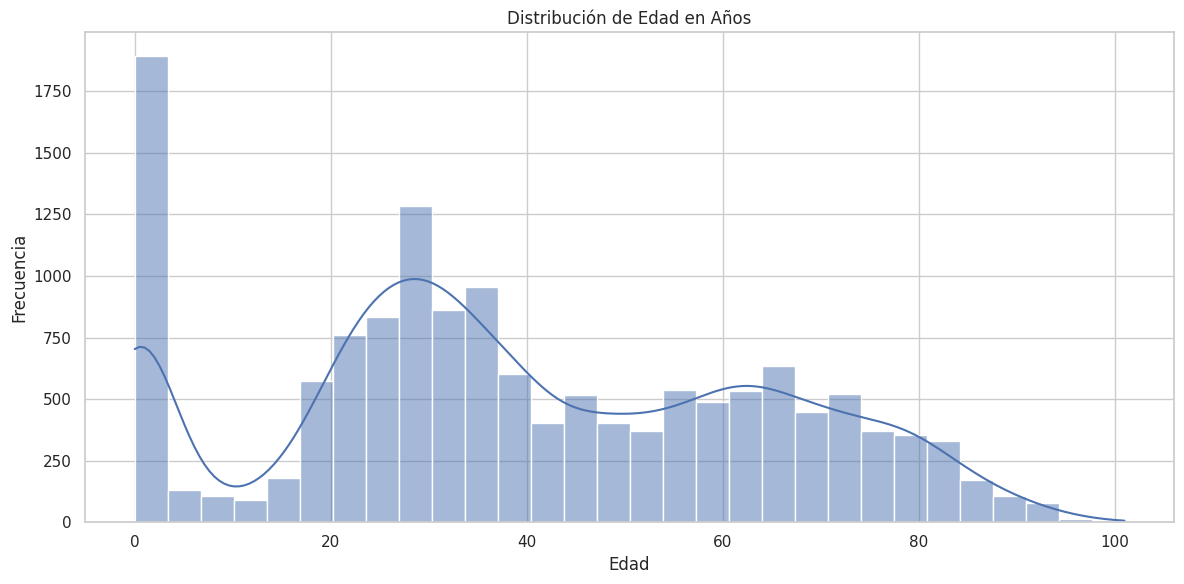

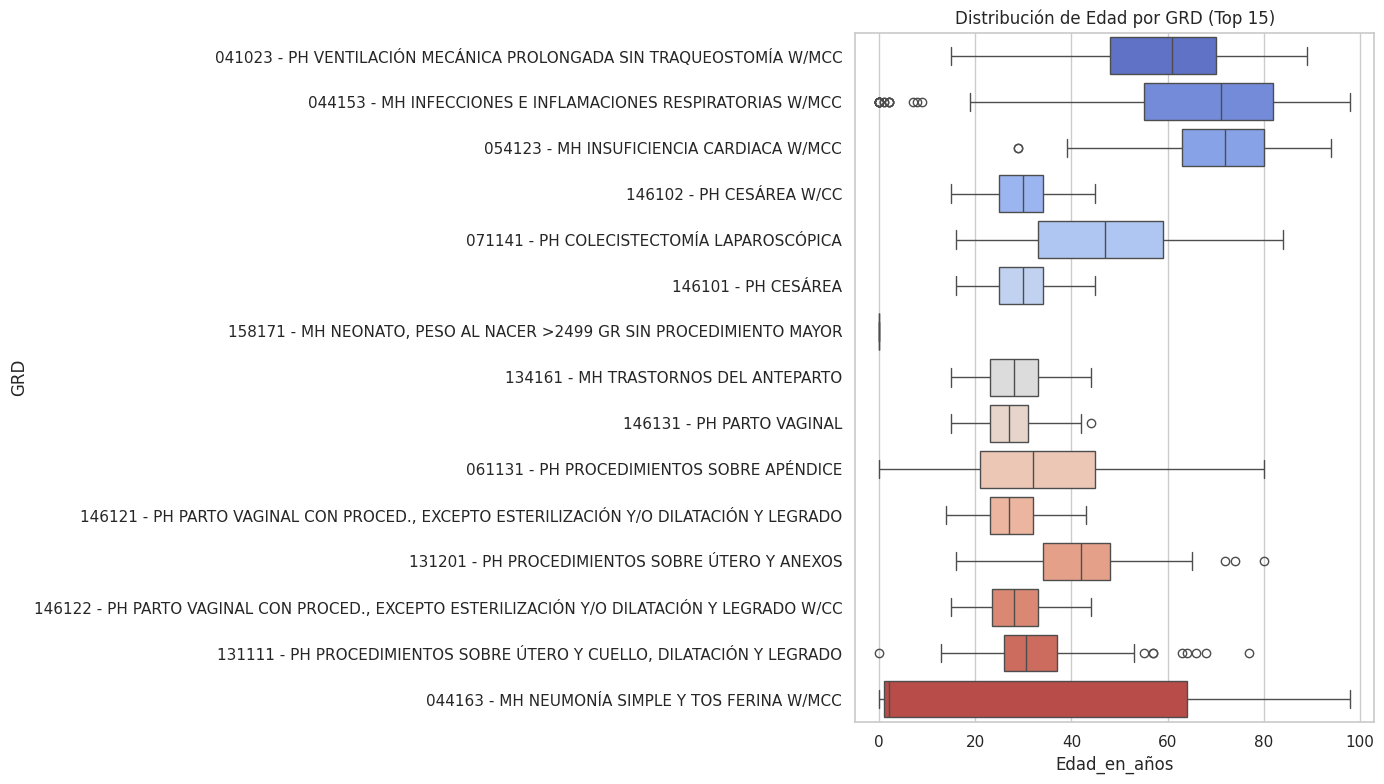




count     14560
unique        2
top       Mujer
freq       9616
Name: Sexo_Desc, dtype: object

Distribución porcentual de sexo:
Sexo_Desc
Mujer     66.043956
Hombre    33.956044
Name: proportion, dtype: float64


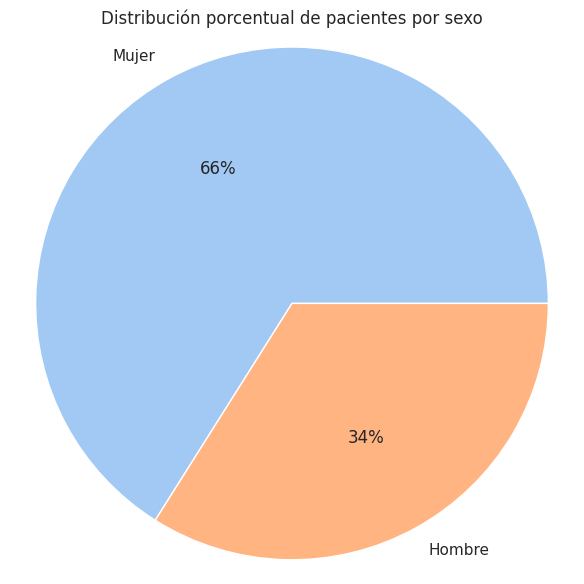

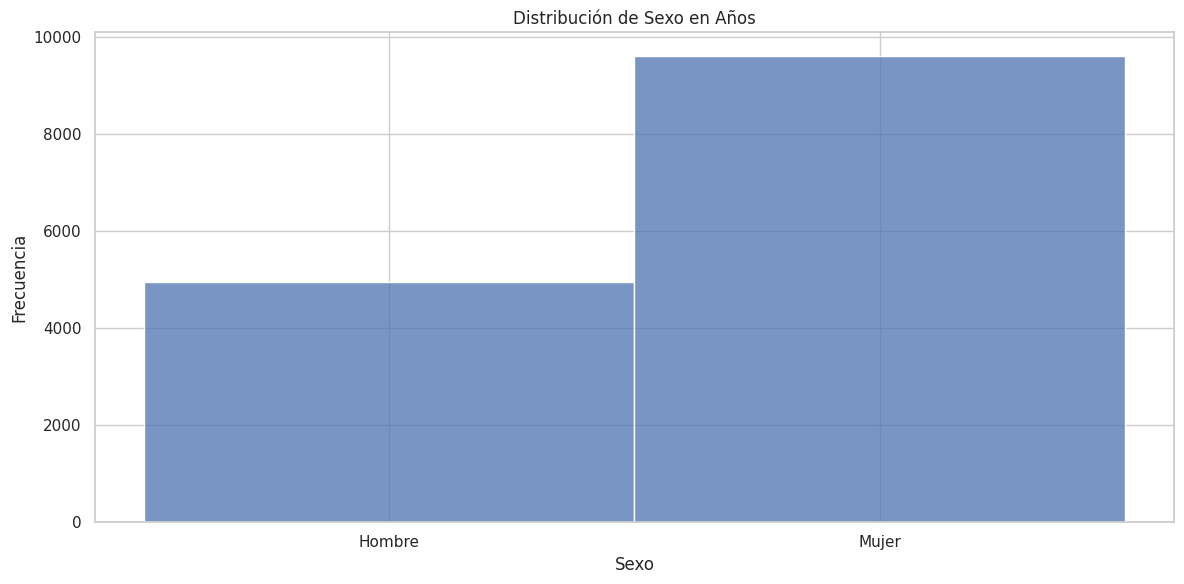

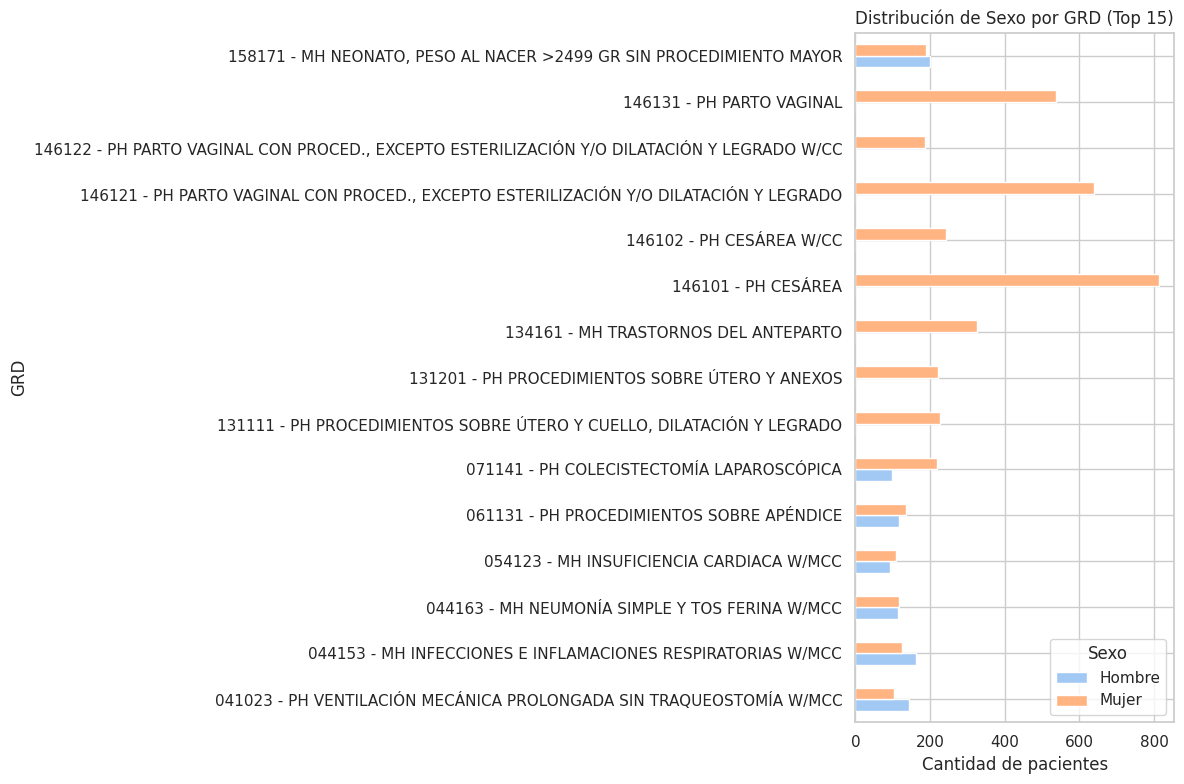

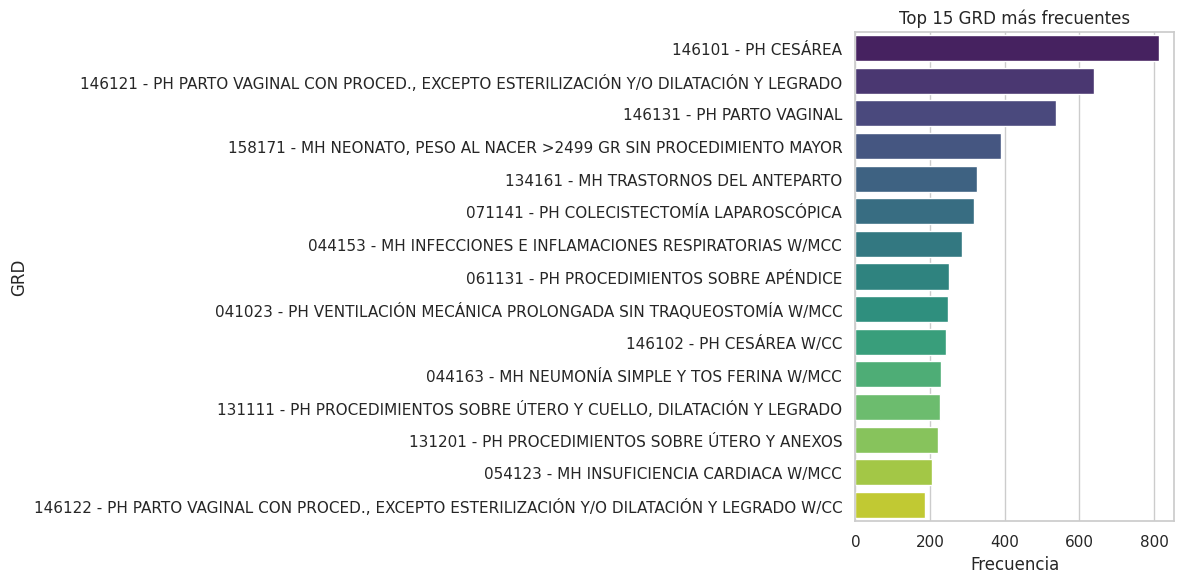

In [ ]:
# ANÁLLISIS DE DATOS

# Outliers Edad
total_filas = df_datasetPandasOriginal.shape[0]
filtro_edad_valida = (df_datasetPandasOriginal["Edad_en_años"] >= 0) & (df_datasetPandasOriginal["Edad_en_años"] <= 110)
filas_validas = df_datasetPandasOriginal[filtro_edad_valida].shape[0]
outliers = total_filas - filas_validas

print(f"Filas totales: {total_filas}")
print(f"Filas válidas (edad entre 0 y 110): {filas_validas}")
print(f"Outliers a eliminar: {outliers}")

df_datasetPandasOriginal = df_datasetPandasOriginal[filtro_edad_valida].copy()

# Porcentaje de nulos por columna
porcentaje_nulos = df_datasetPandasOriginal.isnull().mean().sort_values(ascending=False).to_frame(name="Porcentaje_nulos")
print(porcentaje_nulos)

sns.set(style="whitegrid")

print("\n\n")

# Top 15 GRDs más frecuentes
top_grd = df_datasetPandasOriginal["GRD"].value_counts().nlargest(15)
grd_frecuentes = top_grd.index.tolist()
df_filtrado = df_datasetPandasOriginal[df_datasetPandasOriginal["GRD"].isin(grd_frecuentes)]

# DESCRIPTTIVA EDAD
# Estadísticas generales de la variable Edad
print(df_datasetPandasOriginal["Edad_en_años"].describe())

# Histograma de edad
plt.figure(figsize=(12, 6))
sns.histplot(df_datasetPandasOriginal["Edad_en_años"], bins=30, kde=True)
plt.title("Distribución de Edad en Años")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
print("\n\n")

# Boxplot Edad vs GRD

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_filtrado, x="Edad_en_años", y="GRD", hue="GRD", palette="coolwarm", legend=False)
plt.title("Distribución de Edad por GRD (Top 15)")
plt.xlabel("Edad_en_años")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()
print("\n\n")

# DESCRIPTIVA SEXO
# Estadísticas generales de la variable Sexo
print(df_datasetPandasOriginal["Sexo_Desc"].describe())

# Distribución porcentual por sexo
porcentaje_sexo = df_datasetPandasOriginal["Sexo_Desc"].value_counts(normalize=True) * 100
print("\nDistribución porcentual de sexo:")
print(porcentaje_sexo)

# Gráfico circular
plt.figure(figsize=(6, 6))
plt.pie(porcentaje_sexo, labels=porcentaje_sexo.index, autopct='%1.0f%%', colors=sns.color_palette("pastel"))
plt.title("Distribución porcentual de pacientes por sexo")
plt.axis("equal")  # Para asegurar que el círculo no esté deformado
plt.tight_layout()
plt.show()
print("\n\n")

# Histograma de Sexo
plt.figure(figsize=(12, 6))
sns.histplot(df_datasetPandasOriginal["Sexo_Desc"], bins="auto", kde=False)
plt.title("Distribución de Sexo en Años")
plt.xlabel("Sexo")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
print("\n\n")

# Boxplot Sexo vs GRD

# Crear tabla cruzada de conteo por GRD y Sexo
conteo_grd_sexo = df_filtrado.groupby(["GRD", "Sexo_Desc"]).size().unstack(fill_value=0)

# Gráfico de barras agrupadas
conteo_grd_sexo.plot(kind="barh", stacked=False, figsize=(12, 8), color=sns.color_palette("pastel"))
plt.title("Distribución de Sexo por GRD (Top 15)")
plt.xlabel("Cantidad de pacientes")
plt.ylabel("GRD")
plt.legend(title="Sexo")
plt.tight_layout()
plt.show()
print("\n\n")

# GRD
# Gráfico de barras Frecuencia GRD
plt.figure(figsize=(12, 6))
sns.barplot(y=top_grd.index, x=top_grd.values, orient="h", hue=top_grd.index, palette="viridis", legend=False)
plt.title("Top 15 GRD más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

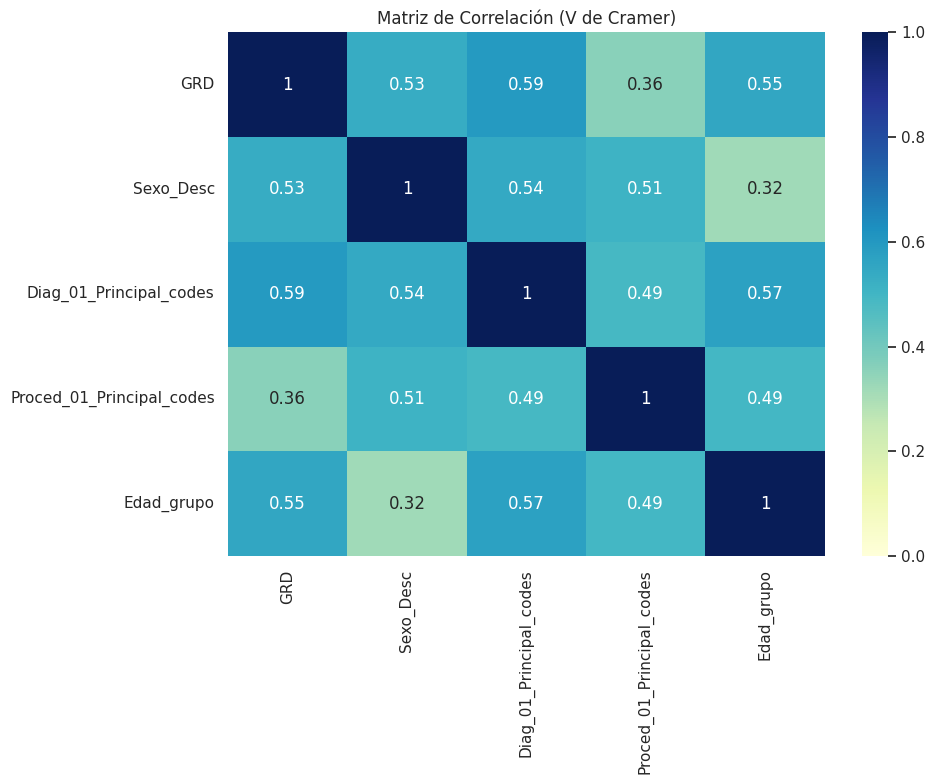

In [ ]:
# Correlación de variables con V de Cramer

# Seleccionar variables categóricas para el análisis
categorial_columns = ["GRD", "Sexo_Desc", "Diag_01_Principal_codes", "Proced_01_Principal_codes", "Edad_grupo"]

# Crear matriz de V de Cramer
matriz_v = pd.DataFrame(index=categorial_columns, columns=categorial_columns)

for col1 in categorial_columns:
    for col2 in categorial_columns:
        if col1 == col2:
            matriz_v.loc[col1, col2] = 1.0
        else:
            matriz_v.loc[col1, col2] = cramers_v(df_datasetPandasOriginal[col1], df_datasetPandasOriginal[col2])

# Convertir a float
matriz_v = matriz_v.astype(float)

# Mostrar heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_v, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
plt.title("Matriz de Correlación (V de Cramer)")
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionar columnas necesarias
df_modelo = df_datasetPandasOriginal[[
    "GRD",
    "Sexo_Desc",
    "Diag_01_Principal_codes",
    "Proced_01_Principal_codes",
    "Edad_grupo"
]]

X = df_modelo.drop(columns="GRD")
y = df_modelo["GRD"]

# === OPCIÓN 1: Usar solo top 50 GRD más frecuentes ===

top_grds = y.value_counts().nlargest(50).index
X_filtrado = X[y.isin(top_grds)]
y_filtrado = y[y.isin(top_grds)]

# === OPCIÓN 2: Usar todas las clases con al menos 2 muestras ===

# clases_validas = y.value_counts()[y.value_counts() >= 2].index
# X_filtrado = X[y.isin(clases_validas)]
# y_filtrado = y[y.isin(clases_validas)]

# === Split y oversampling ===
X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.2, random_state=42, stratify=y_filtrado
)

ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Codificación de variables categóricas
categorical_features = X.columns.tolist()
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Definir modelos a evaluar
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Evaluar todos los modelos
for nombre, modelo in modelos.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])

    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test)

    reporte = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    df_reporte = pd.DataFrame(reporte).transpose()

    # Imprimir resumen
    print(f"\n=== {nombre} ===")
    print("Accuracy:", reporte["accuracy"])
    print("\nMacro Average:")
    print(df_reporte.loc["macro avg"])
    print("\nWeighted Average:")
    print(df_reporte.loc["weighted avg"])


=== Logistic Regression ===
Accuracy: 0.660149511213341

Macro Average:
precision       0.661254
recall          0.656859
f1-score        0.649052
support      1739.000000
Name: macro avg, dtype: float64

Weighted Average:
precision       0.697444
recall          0.660150
f1-score        0.668711
support      1739.000000
Name: weighted avg, dtype: float64

=== Random Forest ===
Accuracy: 0.6497987349051179

Macro Average:
precision       0.620250
recall          0.616417
f1-score        0.609199
support      1739.000000
Name: macro avg, dtype: float64

Weighted Average:
precision       0.666348
recall          0.649799
f1-score        0.651096
support      1739.000000
Name: weighted avg, dtype: float64

=== Gradient Boosting ===
Accuracy: 0.6733755031627372

Macro Average:
precision       0.670745
recall          0.660134
f1-score        0.655723
support      1739.000000
Name: macro avg, dtype: float64

Weighted Average:
precision       0.708142
recall          0.673376
f1-score      

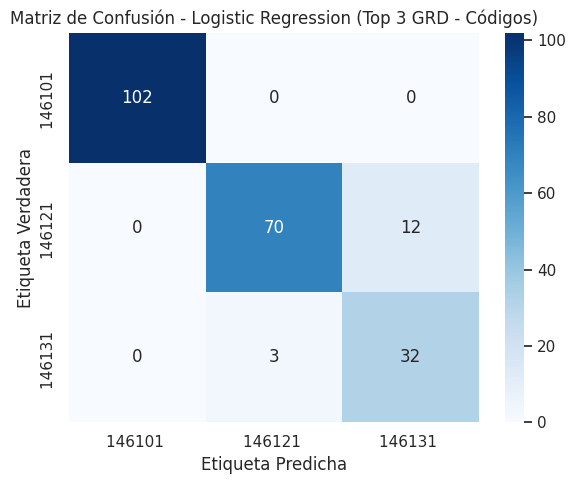

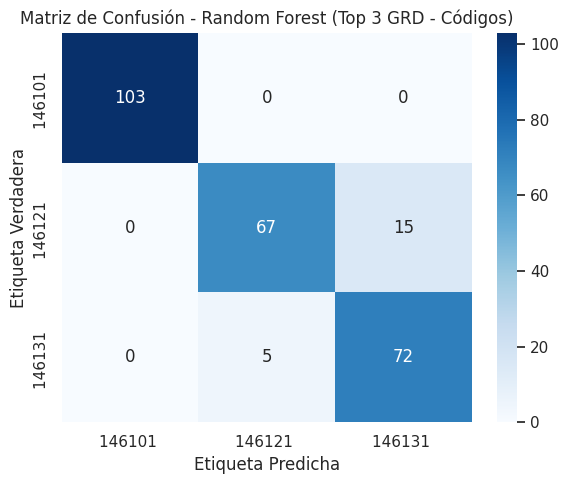

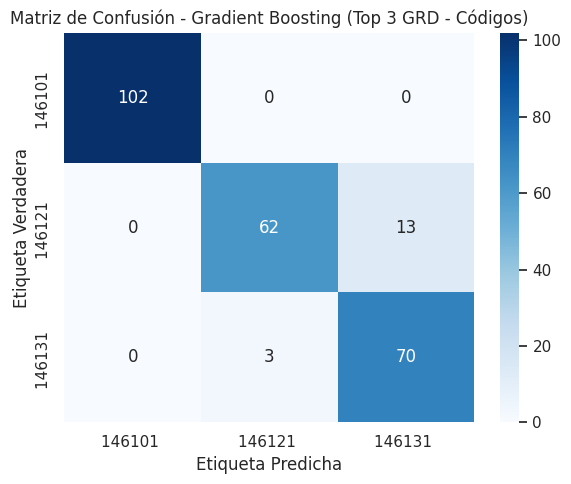

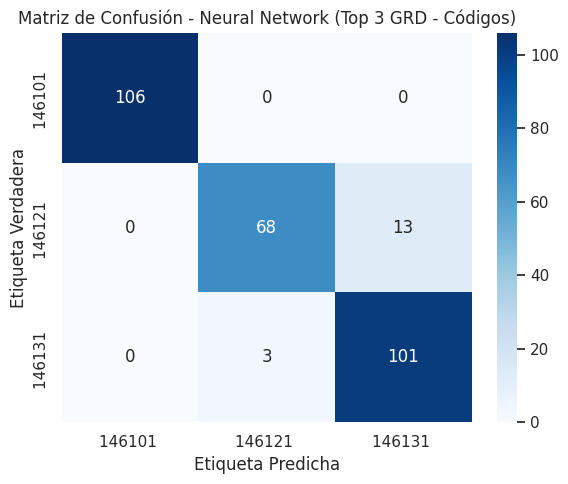

In [ ]:
# === Asegurar y transformar etiquetas ===
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_test_codes = y_test_series.str.split('-').str[0]

# Obtener top 3 GRD más frecuentes por código
top3_codes = y_test_codes.value_counts().nlargest(3).index.tolist()

# Crear máscara de top 3
mask_top3 = y_test_codes.isin(top3_codes)
y_test_top3 = y_test_codes[mask_top3].reset_index(drop=True)

# === Generar matriz para cada modelo ===
for nombre, modelo in modelos.items():
    # Obtener predicciones del modelo actual
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pd.Series(pipeline.predict(X_test)).reset_index(drop=True)
    y_pred_codes = y_pred.str.split('-').str[0]

    # Filtrar solo top 3
    y_pred_top3 = y_pred_codes[mask_top3].reset_index(drop=True)

    # Matriz de confusión
    cm = confusion_matrix(y_test_top3, y_pred_top3, labels=top3_codes)

    # Visualización
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=top3_codes, yticklabels=top3_codes)
    plt.title(f"Matriz de Confusión - {nombre} (Top 3 GRD - Códigos)")
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Verdadera")
    plt.tight_layout()
    plt.show()
    print("\n\n")